In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH="../../../Datas/Grape/"
PATH_SHUFFLE="../../../Datas/shuffle/"
PATH_NEW_DATAS="../../../Datas/new/"
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
EPOCHS = 5
INIT_LR =1e-4

In [3]:
from IA.CNN.common.data_generation import shuffle_images_in_directories

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

shuffle_images_in_directories(PATH+"BLACK_ROT/", PATH_SHUFFLE+"BLACK_ROT/", IMG_SIZE)
shuffle_images_in_directories(PATH+"ESCA/", PATH_SHUFFLE+"ESCA/", IMG_SIZE)
shuffle_images_in_directories(PATH+"HEALTHY/", PATH_SHUFFLE+"HEALTHY/", IMG_SIZE)
shuffle_images_in_directories(PATH+"LEAF_BLIGHT/", PATH_SHUFFLE+"LEAF_BLIGHT/", IMG_SIZE)

train_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=PATH_SHUFFLE,
                                               shuffle=True,
                                               target_size=IMG_SIZE,
                                               subset="training",
                                               class_mode='categorical')

val_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=PATH_SHUFFLE,
                                             shuffle=True,
                                             target_size=IMG_SIZE,
                                             subset="validation",
                                             class_mode='categorical')

Found 11099 images belonging to 4 classes.
Found 2773 images belonging to 4 classes.


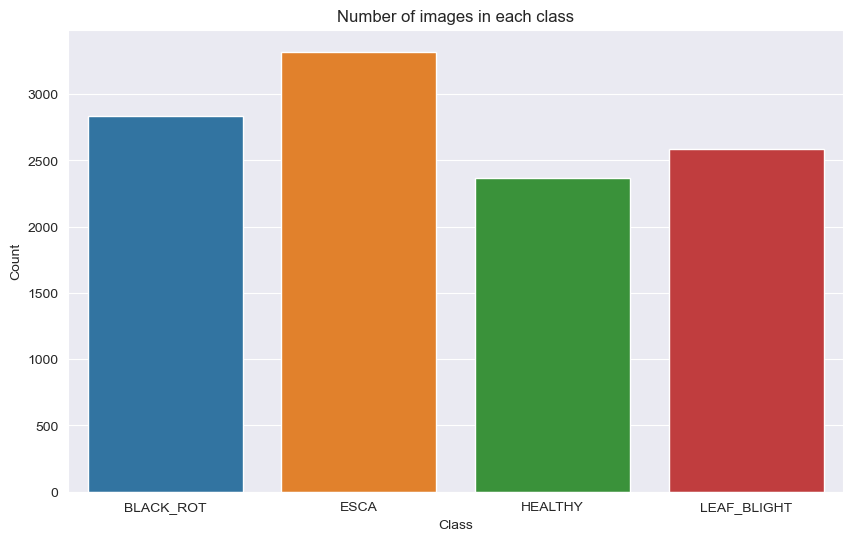

In [4]:
# Get class labels
class_labels = list(train_ds.class_indices.keys())

# Get number of images in each class
class_counts = np.bincount(train_ds.labels)

# Create a DataFrame with class labels and counts
class_counts_df = pd.DataFrame({
    'Class': class_labels,
    'Count': class_counts
})

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts_df, x='Class', y='Count')
plt.title('Number of images in each class')
plt.show()

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) # R,G,B Channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [8]:
# Add a global spatial average pooling layer
out = base_model.output
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
predictions = tf.keras.layers.Dense(4, activation='softmax')(out)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers and use theyas feature extractor trained ln imagenet
for layer in base_model.layers:
    layer.trainable = False

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

In [9]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

44/44 [==============================] - 22s 430ms/step - loss: 1.7319 - accuracy: 0.2120
initial loss: 1.73
initial accuracy: 0.21


In [10]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/5
174/174 [==============================] - 85s 458ms/step - loss: 0.8652 - accuracy: 0.6389 - val_loss: 0.5825 - val_accuracy: 0.7735
Epoch 2/5
174/174 [==============================] - 20s 117ms/step - loss: 0.5412 - accuracy: 0.7855 - val_loss: 0.5006 - val_accuracy: 0.7905
Epoch 3/5
174/174 [==============================] - 20s 116ms/step - loss: 0.4582 - accuracy: 0.8174 - val_loss: 0.4497 - val_accuracy: 0.8107
Epoch 4/5
174/174 [==============================] - 21s 118ms/step - loss: 0.4023 - accuracy: 0.8429 - val_loss: 0.4382 - val_accuracy: 0.8258
Epoch 5/5
174/174 [==============================] - 20s 113ms/step - loss: 0.3699 - accuracy: 0.8545 - val_loss: 0.4209 - val_accuracy: 0.8240


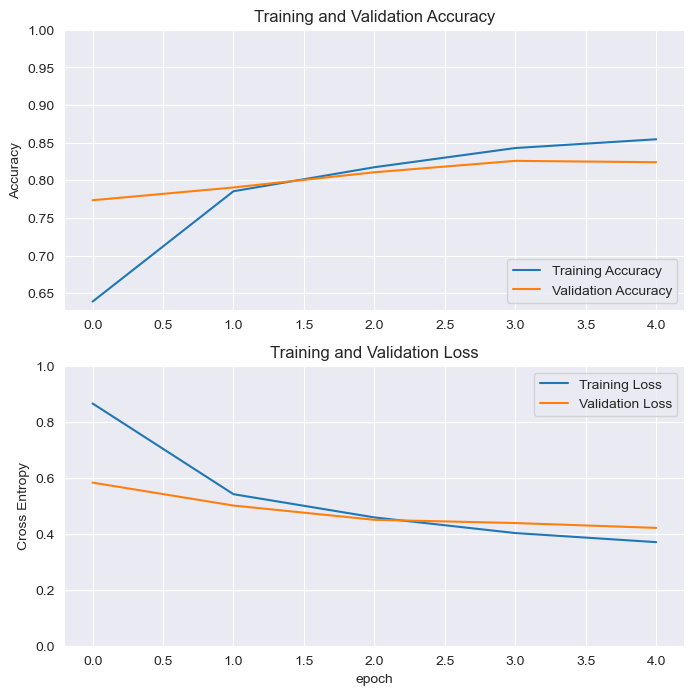

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [14]:
fine_tune_epochs = 5
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
174/174 [==============================] - 20s 114ms/step - loss: 0.3335 - accuracy: 0.8683 - val_loss: 0.3770 - val_accuracy: 0.8493
Epoch 6/10
174/174 [==============================] - 20s 114ms/step - loss: 0.3095 - accuracy: 0.8804 - val_loss: 0.3762 - val_accuracy: 0.8446
Epoch 7/10
174/174 [==============================] - 21s 119ms/step - loss: 0.2844 - accuracy: 0.8916 - val_loss: 0.3880 - val_accuracy: 0.8395
Epoch 8/10
174/174 [==============================] - 20s 117ms/step - loss: 0.2629 - accuracy: 0.9022 - val_loss: 0.3942 - val_accuracy: 0.8395
Epoch 9/10
174/174 [==============================] - 20s 117ms/step - loss: 0.2421 - accuracy: 0.9119 - val_loss: 0.3387 - val_accuracy: 0.8586
Epoch 10/10
174/174 [==============================] - 21s 118ms/step - loss: 0.2187 - accuracy: 0.9199 - val_loss: 0.3151 - val_accuracy: 0.8687


In [15]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

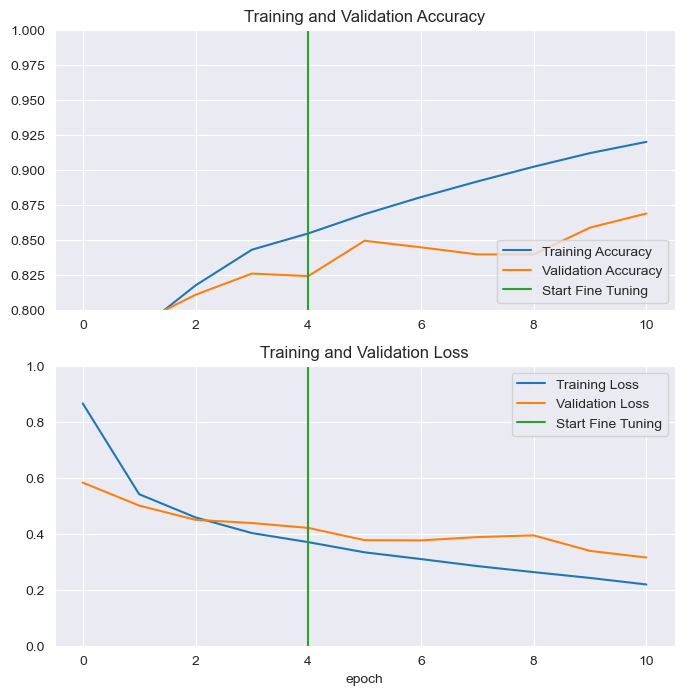

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
final_loss, final_accuracy = model.evaluate(val_ds)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}".format(final_accuracy))

44/44 [==============================] - 4s 93ms/step - loss: 0.3151 - accuracy: 0.8687
Final loss: 0.32
Final accuracy: 0.87


In [18]:
model.save('model.h5')